In [1]:
import torch
import torchvision
from torchvision import transforms, models
from PIL import  Image
import matplotlib.pyplot as plt
from torch.autograd import Variable
import copy

%matplotlib inline

In [16]:
transform = transforms.Compose([transforms.Resize([224,224]),
                               transforms.ToTensor()])

def loadimg(path = None):
    img = Image.open(path)
    img = transform(img)
    img = img.unsqueeze(0)
    return img
    
ToPIL = torchvision.transforms.ToPILImage()
    
def img_show(img, title = None):
    img = img.clone().cpu()
    img = img.view(3,224,224)
    img = ToPIL(img)

    if title is not None:
        plt.title(title)
    plt.imshow(img)

In [3]:
content_img = loadimg("res/content4.jpg")
content_img = Variable(content_img).cuda()
style_img = loadimg("res/style5.jpg")
style_img = Variable(style_img).cuda()

In [4]:
print(content_img.size())

torch.Size([1, 3, 224, 224])


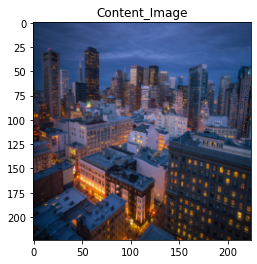

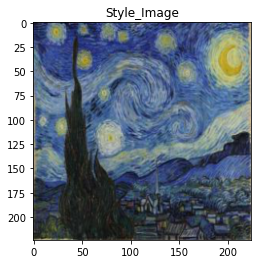

In [5]:
plt.figure()
img_show(content_img.data, title = "Content_Image")
plt.figure()
img_show(style_img.data, title = "Style_Image")

定义内容Loss,风格Loss和Gram矩阵

In [6]:
class Content_loss(torch.nn.Module):
    def __init__(self, weight, target):
        super(Content_loss, self).__init__()
        self.weight = weight
        self.target = target.detach()*weight
        self.loss_fn = torch.nn.MSELoss()
        
    def forward(self, input):
        self.loss = self.loss_fn(input*self.weight, self.target)
        self.output = input
        return self.output
        
    def backward(self):
        self.loss.backward(retain_graph = True)
        return self.loss
        
        

In [7]:
class gram_matrix(torch.nn.Module):
    def forward(self, input):
        a,b,c,d = input.size()
        feature = input.view(a*b, c*d)
        gram = torch.mm(feature, feature.t())
        return gram.div(a*b*c*d)
        

In [8]:
class Style_loss(torch.nn.Module):
    def __init__(self, weight, target):
        super(Style_loss, self).__init__()
        self.weight = weight
        self.target = target.detach()*weight
        self.loss_fn = torch.nn.MSELoss()
        self.gram = gram_matrix()
        
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.loss_fn(self.G, self.target)
        return self.output
    def backward(self):
        self.loss.backward(retain_graph = True)
        return self.loss

定义需要优化的参数

迁移模型

In [9]:
use_gpu = torch.cuda.is_available()
cnn = models.vgg16(pretrained=True).features
if use_gpu:
    cnn = cnn.cuda()

In [10]:
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

构造自己的神经网络

In [11]:
content_layer = ["Conv_5","Conv_6"]

style_layer = ["Conv_1", "Conv_2", "Conv_3", "Conv_4", "Conv_5"]



content_losses = []
style_losses = []

conten_weight = 1
style_weight = 1000

new_model = torch.nn.Sequential()

model = copy.deepcopy(cnn)

gram = gram_matrix()

if use_gpu:
    new_model = new_model.cuda()
    gram = gram.cuda()

index = 1
for layer in list(model):
    if isinstance(layer, torch.nn.Conv2d):
        name = "Conv_"+str(index)
        new_model.add_module(name, layer)
        if name in content_layer:
            target = new_model(content_img).clone()
            content_loss = Content_loss(conten_weight, target)
            new_model.add_module("content_loss_"+str(index), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layer:
            target = new_model(style_img).clone()
            target = gram(target)
            style_loss = Style_loss(style_weight, target)
            new_model.add_module("style_loss_"+str(index), style_loss)
            style_losses.append(style_loss)
            
    if isinstance(layer, torch.nn.ReLU):
        name = "Relu_"+str(index)
        new_model.add_module(name, layer)
        index = index+1
            
    if isinstance(layer, torch.nn.MaxPool2d):
        name = "MaxPool_"+str(index)
        new_model.add_module(name, layer)

print(new_model)

Sequential(
  (Conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): Style_loss(
    (loss_fn): MSELoss()
    (gram): gram_matrix()
  )
  (Relu_1): ReLU(inplace=True)
  (Conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): Style_loss(
    (loss_fn): MSELoss()
    (gram): gram_matrix()
  )
  (Relu_2): ReLU(inplace=True)
  (MaxPool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): Style_loss(
    (loss_fn): MSELoss()
    (gram): gram_matrix()
  )
  (Relu_3): ReLU(inplace=True)
  (Conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_4): Style_loss(
    (loss_fn): MSELoss()
    (gram): gram_matrix()
  )
  (Relu_4): ReLU(inplace=True)
  (MaxPool_5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_5): Conv2d(128, 256, k

In [12]:
input_img = content_img.clone()

parameter = torch.nn.Parameter(input_img.data)
optimizer = torch.optim.LBFGS([parameter])

In [13]:
n_epoch = 1000

run = [0]
while run[0] <= n_epoch:

    def closure():
        optimizer.zero_grad()
        style_score = 0
        content_score = 0
        parameter.data.clamp_(0,1)
        new_model(parameter)
        for sl in style_losses:
            style_score += sl.backward()
        
        for cl in content_losses:
            content_score += cl.backward()
        
        run[0] += 1 
        if run[0] % 50 == 0:
            print('{} Style Loss : {:4f} Content Loss: {:4f}'.format(run[0],
                 style_score.item(), content_score.item())) 

        return style_score+content_score
    


    optimizer.step(closure)



50 Style Loss : 1.832912 Content Loss: 6.588260
100 Style Loss : 1.603038 Content Loss: 6.291554
150 Style Loss : 1.485372 Content Loss: 6.212929
200 Style Loss : 1.420210 Content Loss: 6.176701
250 Style Loss : 1.391804 Content Loss: 6.156584
300 Style Loss : 1.378009 Content Loss: 6.146152
350 Style Loss : 1.372905 Content Loss: 6.138058
400 Style Loss : 1.369820 Content Loss: 6.132914
450 Style Loss : 1.368350 Content Loss: 6.128744
500 Style Loss : 1.367044 Content Loss: 6.125669
550 Style Loss : 1.366174 Content Loss: 6.123219
600 Style Loss : 1.365960 Content Loss: 6.120627
650 Style Loss : 1.365510 Content Loss: 6.118679
700 Style Loss : 1.365493 Content Loss: 6.116549
750 Style Loss : 1.364992 Content Loss: 6.115081
800 Style Loss : 1.364995 Content Loss: 6.113196
850 Style Loss : 1.364440 Content Loss: 6.112015
900 Style Loss : 1.364429 Content Loss: 6.110396
950 Style Loss : 1.364789 Content Loss: 6.108392
1000 Style Loss : 1.364836 Content Loss: 6.106841


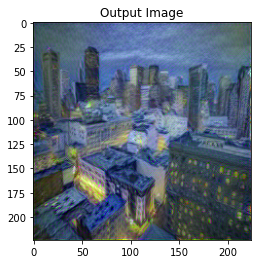

In [14]:
parameter.data.clamp_(0,1)
plt.figure()
img_show(parameter.data, title="Output Image")